In [1]:
from GraphModels.model import *
from GraphModels.solvers import *
from GraphModels.metrics import *
import networkx as nx
import matplotlib.pyplot as plt
import random
from experiments import *

from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2

In [2]:
def f(x, a, b, c):
    return a * np.power(x, b) + c

params = curve_fit(f, np.arange(0.1, 1, 0.1), [0.94, 0.87, 0.85, 0.77, 0.74, 0.68, 0.64, 0.55, 0.4])[0]

In [3]:
N = 20
n = 40
S_exp = 5
S_obs = 1

In [4]:
data = np.stack([familywise_MHT_experiments(CholCorrModel,
                                            MHTSolver(0.05, corr_pvalues),
                                            N,
                                            f(density, *params),
                                            n,
                                            S_exp,
                                            S_obs,
                                            metrics=[TP, FP, FN, TN, FDR],
                                            verbose=True) for density in np.arange(0.1, 1, 0.1)])

Family-wise MHT experiment with 0.913 completed in time: 0.835s
Family-wise MHT experiment with 0.887 completed in time: 0.938s
Family-wise MHT experiment with 0.85 completed in time: 0.654s
Family-wise MHT experiment with 0.802 completed in time: 0.55s
Family-wise MHT experiment with 0.745 completed in time: 0.674s
Family-wise MHT experiment with 0.68 completed in time: 0.965s
Family-wise MHT experiment with 0.606 completed in time: 0.762s
Family-wise MHT experiment with 0.523 completed in time: 0.527s
Family-wise MHT experiment with 0.434 completed in time: 0.573s


In [5]:
data.shape

(9, 5, 5)

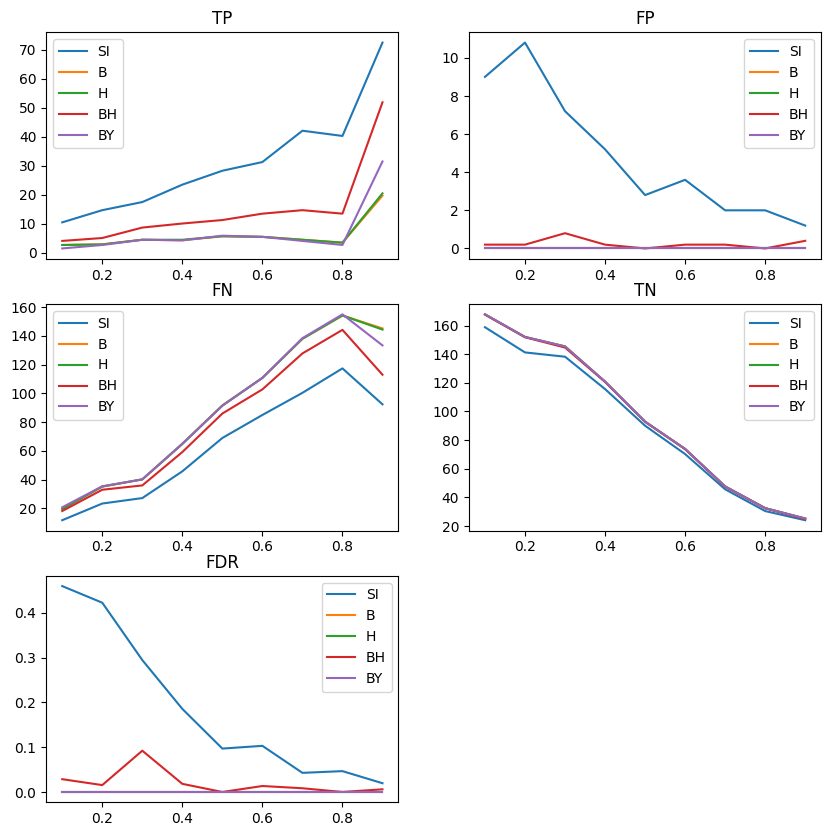

In [6]:
for i, metric in enumerate(['TP', 'FP', 'FN', 'TN', 'FDR']):
    plt.subplot(3, 2, i+1)
    for idx, algo in enumerate(['SI', 'B', 'H', 'BH', 'BY']):
        plt.plot(np.arange(0.1, 1, 0.1), data[:, i, idx], label=algo)
    plt.title(metric)
    plt.legend()
    
plt.gcf().set_size_inches(10, 10)